This code generates data for change-point detection, and returns the change points.

array([[11.52607545,  4.59519449,  4.67555701,  4.59757868],
       [11.51414772,  5.7042166 ,  4.66389146,  4.59240007],
       [11.51406205,  6.18192544,  4.8720547 ,  4.61013212],
       [11.49450031,  6.62279212,  5.14522631,  4.60276751],
       [11.53503059,  7.02974585,  5.47090452,  4.65353381],
       [11.46530398,  7.30293166,  5.825349  ,  4.63586084],
       [11.5163372 ,  7.69529132,  6.19315154,  4.65728745],
       [11.47534268,  8.01080665,  6.55537119,  4.67606772],
       [11.45870711,  8.34588359,  6.8696154 ,  4.73932252],
       [11.44187738,  8.71730099,  7.20528118,  4.82691973],
       [11.39470489,  8.98509996,  7.54356708,  4.85676344],
       [11.36741762,  9.34880815,  7.9010946 ,  4.944803  ],
       [11.28766857,  9.60523149,  8.22811895,  5.04212502],
       [11.17344719,  9.86659299,  8.47774216,  5.19784412],
       [11.0964259 , 10.20876615,  8.80965579,  5.31850034],
       [10.9348282 , 10.39803116,  9.06042044,  5.46071047],
       [10.86665901, 10.

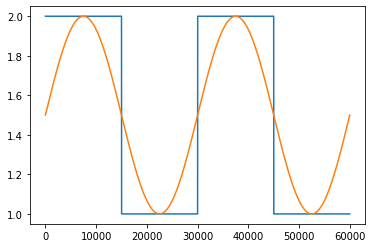

In [125]:
import numpy as np
import pickle
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
import matplotlib.pyplot as plt
import scipy.special as fun
from multiprocessing import Pool


N = 100000.
param=[0.1, 0.1, 0.05]
days = 60
def gen_data(beta_series=None, random=True, lambda0=0.05, days=days, obs_per_day=1, state0=[100000., 100., 100., 100.], 
             lb= 0.5, ub=1.5, linspace=1000, noise=0.03,seed=5):
    """
    random: If True, simulate a change point arrival as poisson process with rate lambda0. 
            If False, input a series of beta with dimension days * obs_per_day * linspace
    lambda0: rate of Poisson arrival
    obs_per_day: measurement per day
    state0: population of S, E, I and D state
    linspace: discretization of 
    params: parameter: [beta, ve, vi, pd]
    noise: noise level of the observation
    param: ve, vi, pd = [0.1, 0.1, 0.05]
    """
    # number of change points
    global N, param
    state_ls = np.ones((days * obs_per_day * linspace, 4))
    step_size = 1. / (linspace * obs_per_day)
    if beta_series is None:
        if seed is not None:
            np.random.seed(seed)
        n_cp = np.random.poisson(lambda0 * days)
        beta_series = np.zeros(days * obs_per_day * linspace)
        
        if seed is not None:
            np.random.seed(seed)
        time = np.sort(np.random.uniform(1, days * obs_per_day * linspace, n_cp).astype(int))
        if seed is not None:
            np.random.seed(seed)
        val = np.random.uniform(lb, ub, n_cp+1)
        for i in range(time[0]):
            beta_series[i] = val[0]
        for idx in range(0, n_cp-1):
            beta_series[time[idx]:time[idx+1]] = val[idx+1]
        for i in range(time[-1], len(beta_series)):
            beta_series[time[-1]:] = val[-1]
    state_ls = np.zeros((days * linspace * obs_per_day, 4))    
    for i in range(4):
        state_ls[0][i] = state0[i]
    ve, vi, pd = param[0], param[1], param[2]
    plt.plot(beta_series)
    for i in range(1, linspace * days * obs_per_day):
        state_ls[i][0] = state_ls[i - 1][0] - step_size * beta_series[i-1] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * beta_series[i-1] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * ve * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * ve * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * vi * pd
    states = state_ls[::linspace]
    if seed is not None:
        np.random.seed(seed)
    states2 = states * np.random.normal(1, noise, states.shape)
    return np.log(states2), np.log(states), beta_series#, n_cp, time/(linspace*obs_per_day), beta_series  

x = np.linspace(0, 4 * np.pi, 60000)
# beta_series0 = 0.5 * np.sin(x) + 1.5
beta_series = np.concatenate((2.0 * np.ones(15000), 1.0 * np.ones(15000), 2.0 * np.ones(15000), 1.0 * np.ones(15000)))
observations, true_data, true_beta = gen_data(beta_series=beta_series) # beta_series=beta_series
plt.plot(beta_series0)
observations

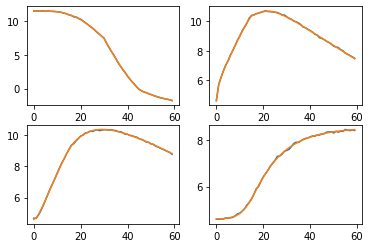

In [126]:
plt.subplot(2, 2, 1)
plt.plot(observations[:, 0])
plt.plot(true_data[:, 0])
plt.subplot(2, 2, 2)
plt.plot(observations[:, 1])
plt.plot(true_data[:, 1])
plt.subplot(2, 2, 3)
plt.plot(observations[:, 2])
plt.plot(true_data[:, 2])
plt.subplot(2, 2, 4)
plt.plot(observations[:, 3])
plt.plot(true_data[:, 3])

In [133]:
# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * 0.25 * theta[2]
    return resultDtheta



def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])





days = 60
discretization = 1
obs_per_day = 1
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, 1., 1., 1.])
param_names = ['re', 've', 'vi', 'pd']
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 80000, 15000, 60000]
yobs = observations
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = days * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])


# First stage: use MAGI package to optimize theta as constant #####################


result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
print(inferred_theta)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
            Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
            mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
        )
        CovAllDimensionsPyList.append(each_pycov)

[1.47717734 0.10194755 0.10739533 0.18765174]


In [136]:
def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - constant_param_ls[0]  # (2)
    logIdt = torch.exp(logE - logI) * constant_param_ls[0] - constant_param_ls[1]  # (3)
    # reparametrize on pd
    logDdt = torch.exp(logI - logD) * 0.25 * constant_param_ls[1] * constant_param_ls[2]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


is_time_varying=[True, False, False, False]
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e12
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 -314.80330456073847
200 -323.16415102891415
400 -331.4698917108075
600 -339.90265732721974
800 -348.2554824752688
1000 -356.4789781967764
1200 -364.60044997643564
1400 -372.68192531177294
1600 -380.7814333134246
1800 -388.9354586345938
2000 -397.1625610185707
2200 -405.4667959345732
2400 -413.84339830176066
2600 -422.2653633515411
2800 -430.7056286385391
3000 -439.1236337733302
3200 -447.47175023013716
3400 -455.696662321907
3600 -463.74307907726995
3800 -471.55731398874605
4000 -479.0934319992895
4200 -486.3264285632438
4400 -493.2338244604899
4600 -499.81871886813286
4800 -506.09473165320503
5000 -512.0867852353509
5200 -517.8222556694582
5400 -523.3466027709826
5600 -528.6806041851253
5800 -533.857777028906
6000 -538.9039694546648
6200 -543.8439058378601
6400 -548.6949086415659
6600 -553.4732563045668
6800 -558.1857133428987
7000 -562.8702518767384
7200 -567.5089312987676
7400 -572.1210136177384
7600 -576.7155120936486
7800 -581.3009388496596
8000 -585.8851313963468
8200 -590.4758

In [131]:
theta_dim

4

Text(0.5, 1.0, 'D')

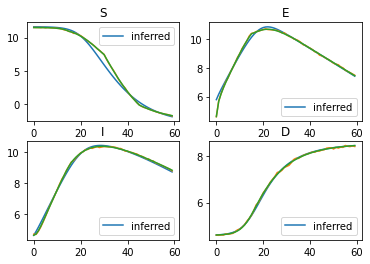

In [137]:
plt.subplot(2, 2, 1)
dim_idx = 0
plt.plot(np.arange(0, 60, 1), inferred_trajectory.transpose()[:, dim_idx], label='inferred')
plt.plot(observations[:, dim_idx])
plt.plot(true_data[:, dim_idx])
plt.legend()
plt.title('S')
plt.subplot(2, 2, 2)
dim_idx = 1
plt.plot(np.arange(0, 60, 1), inferred_trajectory.transpose()[:, dim_idx], label='inferred')
plt.plot(observations[:, dim_idx])
plt.plot(true_data[:, dim_idx])
plt.legend()
plt.title('E')
plt.subplot(2, 2, 3)
dim_idx = 2
plt.plot(np.arange(0, 60, 1), inferred_trajectory.transpose()[:, dim_idx], label='inferred')
plt.plot(observations[:, dim_idx])
plt.plot(true_data[:, dim_idx])
plt.legend()
plt.title('I')
plt.subplot(2, 2, 4)
dim_idx = 3
plt.plot(np.arange(0, 60, 1), inferred_trajectory.transpose()[:, dim_idx], label='inferred')
plt.plot(observations[:, dim_idx])
plt.plot(true_data[:, dim_idx])
plt.legend()
plt.title('D')

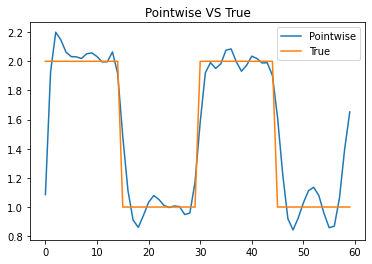

In [149]:
import matplotlib.pyplot as plt
pointwise_xlatent_torch1 = torch.tensor(xInitExogenous, dtype=torch.double)
pointwise_xlatent_torch2 = torch.tensor(inferred_trajectory.transpose(), dtype=torch.double)
pointwise_xlatent_torch3 = torch.tensor(true_data, dtype=torch.double)
plt.plot(pointwise_theta_torch.detach().numpy()[:, 0], label='Pointwise')
plt.plot(true_beta[::1000], label='True')
plt.title('Pointwise VS True')
plt.legend()
plt.show()
true_theta_torch = torch.tensor(true_beta.reshape(-1, 1))


In [352]:
def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)

# value list, one dimension higher than cpt_ls

# likelihood_vals = np.zeros()
# detach grad of x, sigma etc
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])
    
def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day):
    new_theta = construct(vals, occurence_times)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day)



vals = pointwise_theta_torch.detach().clone()
# Initialize occurence times, sum(cur_occurence_times) = len(theta)
occurence_times = np.ones(len(vals)).astype(int)
pointwise_xlatent_torch.requires_grad = False
sigma_torch.requires_grad = False
total_iter = 58
vals_ls = np.zeros((total_iter, len(vals)))
occurence_times_ls = np.zeros((total_iter, len(vals)))
lik_ls = np.zeros(len(vals))
for EachIter in range(total_iter):
    print('Iteration: ', EachIter, '\n')
    n_clusters = np.count_nonzero(occurence_times)
    cur_loss = np.inf
    cur_best_idx = -1
    cur_occurence_times = occurence_times.copy()
    for idx in range(len(vals)-1):
        if occurence_times[idx] == 0:
            continue
        else:
            print('Current index: ', idx)
            # find the next index of theta value
            next_idx = idx + 1
            while next_idx <= len(vals)-1:
                if occurence_times[next_idx]:
                    break
                next_idx += 1
            # if there is no such next index, continue to the next iteration  
            if next_idx >= len(vals):
                continue      
            cur_vals = vals.detach().clone()
#             new_val_tmp = (cur_vals[idx] + cur_vals[next_idx]) / 2
            new_val_tmp = (occurence_times[idx] * cur_vals[idx] + occurence_times[next_idx] * cur_vals[next_idx]) / (occurence_times[idx] + occurence_times[next_idx])
            new_vals_tmp = cur_vals.detach().clone()
            new_vals[idx], new_vals[next_idx] = new_val, new_val
            new_occurence_times = cur_occurence_times.copy()
            new_occurence_times[idx] = cur_occurence_times[idx] + cur_occurence_times[next_idx]
            new_occurence_times[next_idx] = 0
            pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
            pointwise_xlatent_torch_tmp.requires_grad = True
            new_vals_tmp.requires_grad = True
            time_constant_param_ls_tmp = time_constant_param_ls.copy()
            sigma_torch_tmp = sigma_torch.detach().clone()
            # Define new initial theta
            print(new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls_tmp, sigma_torch_tmp,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature, obs_per_day))
            pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, new_vals_tmp, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
            pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
            cur_loss_tmp = np.inf
            for epoch in range(100000):
                pointwise_optimizer.zero_grad()
                # compute loss function
                llik = new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls, sigma_torch,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature, obs_per_day)
                new_loss = -llik
                if epoch % 200 == 0:
                    print(epoch, new_loss.item())
                    diff = new_loss.item() - cur_loss_tmp
                    if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
                        break
                    cur_loss_tmp = new_loss.item()
                new_loss.backward()
                pointwise_optimizer.step()
                pointwise_lr_scheduler.step()
            if cur_loss > new_loss.item():
                cur_loss = new_loss.item()
                cur_best_idx = idx
                cur_best_occurence_times = new_occurence_times.copy()
                print('Update change point!')
                cur_best_vals = new_vals_tmp.detach().clone()
                print('Updated change point list: ', cur_best_occurence_times)
                cur_best_xlatent = pointwise_xlatent_torch_tmp.detach().clone()
    occurence_times = cur_best_occurence_times.copy()
    occurence_times_ls[EachIter] = occurence_times.copy()
    vals = cur_best_vals.clone()
    vals_ls[EachIter] = vals.detach().numpy()[:, 0]
    pointwise_xlatent_torch = cur_best_xlatent.clone()
    lik_ls[EachIter] = cur_loss

Iteration:  0 

Current index:  0
tensor(-200.8167, dtype=torch.float64, grad_fn=<SumBackward0>)
0 200.81666267113235
200 -164.9666284643768
400 -363.61728310386746
600 -462.15008314653767
800 -505.28164208391263
1000 -523.9668943030134
1200 -533.830052641463
1400 -540.8490151191279
1600 -546.8922108436875
1800 -552.422427663912
2000 -557.5271878584364
2200 -562.2034430228621
2400 -566.4424419570321
2600 -570.2398236360906
2800 -573.6364152076466
3000 -576.6496591448079
3200 -579.3012117878739
3400 -581.6401882127877
3600 -583.689325846803
3800 -585.4994146262466
4000 -587.0885043682622
4200 -588.4911878804471
4400 -589.7350297445159
4600 -590.846250398405
4800 -591.8473081716533
5000 -592.7590638058491
Update change point!
Updated change point list:  [2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Current index:  1
tensor(624.5945, dtype=torch.float64, grad_fn=<SumBackward0>)
0 -624.5944621973703
200 -659.59340

In [346]:
grad_ls.shape

(58,)

In [353]:
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])


for i in range(58):
    print(i)
    plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
    plt.plot(true_beta[::1000])
    plt.title(str(i+1) + 'th Iteration: loss = '+ str(lik_ls[i]))
    plt.savefig('new-plots/plot-'+str(i)+'.png')
    plt.clf()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


<Figure size 432x288 with 0 Axes>

array([ 1., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

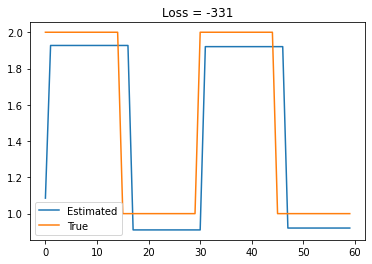

Text(0.5, 1.0, 'Loss change until convergence')

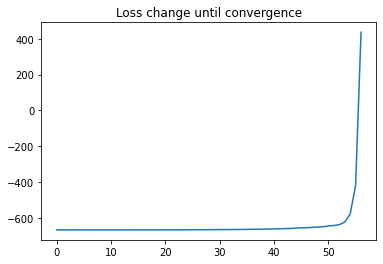

In [355]:
plt.plot(np.arange(0, 57, 1), lik_ls[:57])
# plt.scatter(54, lik_ls[54])  # CUSUM stopping rule
# stopping rule principled 
plt.title('Loss change until convergence')

In [ ]:
plt.plot(construct(new_vals_tmp, occurence_times_ls[-4].astype(int)).numpy().reshape(-1, 1), label='Estimated')
plt.plot(true_beta[::1000], label='True')
plt.legend()
plt.title('Loss = -331')
occurence_times_ls[-4]

In [341]:
# torch.tensor(vals_ls[-4]).reshape(-1, 1) - pointwise_theta_torch
new_vals_tmp.grad()

TypeError: 'NoneType' object is not callable

In [337]:
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, new_vals_tmp, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
cur_loss_tmp = np.inf
for epoch in range(100000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    new_occurence_times = np.array([14.,  0., 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]).astype(int)
    llik = new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls, sigma_torch,
                                ydata, CovAllDimensionsPyList, fOdeTorch,
                                priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss_tmp
        if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
            break
        cur_loss_tmp = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 88782.26845784744
200 80044.94593477556
400 72378.61767416383
600 65493.94250155953
800 59268.2612669011
1000 53617.79789336626
1200 48477.48727939361
1400 43793.71369422075
1600 39521.07439032566
1800 35620.70975774028
2000 32059.091869232547
2200 28807.025137125238
2400 25838.842598182087
2600 23131.775559087826
2800 20665.49487912809
3000 18421.70632932847
3200 16383.878170412054
3400 14536.963354849166
3600 12867.200417362183
3800 11361.912713855676
4000 10009.373341460177
4200 8798.64915637572
4400 7719.477310743683
4600 6762.165525304921
4800 5917.499350598875
5000 5176.666017101712
5200 4837.723736426415
5400 4512.315637739531
5600 4202.0605011865255
5800 3908.3145346213328
6000 3632.1249688044013
6200 3374.2342340656774
6400 3135.091441216784
6600 2914.8698700869522
6800 2713.485789337215
7000 2530.6223488361775
7200 2365.753897560904
7400 2218.1705453392487
7600 2087.0038090512526
7800 1971.2510470863185
8000 1869.806917256031
8200 1781.4876566263808
8400 1705.0642344321006


Text(0.5, 1.0, 'Loss = 1505')

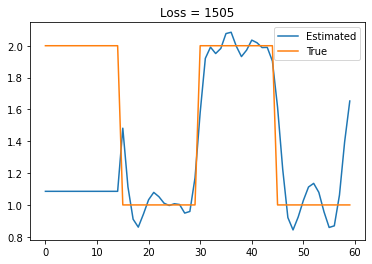

In [317]:
plt.plot(construct(new_vals_tmp, new_occurence_times), label='Estimated')
plt.plot(true_beta[::1000], label='True')
plt.legend()
plt.title('Loss = 1505')

In [335]:
# 八点
true_vals = torch.tensor(true_beta[::1000].reshape(-1, 1))
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, true_vals, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
cur_loss_tmp = np.inf
for epoch in range(100000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    new_occurence_times = np.array([15.,  0., 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  15.,  0., 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  15., 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  15.,  0., 0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]).astype(int)
    llik = new_likelihood(pointwise_xlatent_torch_tmp, true_vals, new_occurence_times, time_constant_param_ls, sigma_torch,
                                ydata, CovAllDimensionsPyList, fOdeTorch,
                                priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss_tmp
        if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
            break
        cur_loss_tmp = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 18682.581725018626
200 13538.077687999861
400 10357.619609124149
600 7958.3947672150425
800 6121.093152574047
1000 4703.47948873574
1200 3606.143551848175
1400 2756.045088943443
1600 2097.3167899447103
1800 1586.314730041156
2000 1188.7366022523736
2200 877.6818066337903
2400 632.2184579409836
2600 436.2775616756204
2800 277.767493033419
3000 147.81717142685036
3200 40.09427098221662
3400 -49.81945399830228
3600 -124.99044793686613
3800 -187.60109280690335
4000 -239.3125634317431
4200 -281.5123140828608
4400 -315.4631108496248
4600 -342.36730984940664
4800 -363.3817753192741
5000 -379.6006256510362
5200 -386.3539577605643
5400 -392.4994280039361
5600 -398.04549419050716
5800 -403.01640049372287
6000 -407.4514961991
6200 -411.40128828963236
6400 -414.9227204320712
6600 -418.07414004921907
6800 -420.9107429800375
7000 -423.48053997676857
7200 -425.8219357440486
7400 -427.9629314665067
7600 -429.9209091059879
7800 -431.7053468280977
8000 -433.319670398723
8200 -434.76378748385275
8400 -

Text(0.5, 1.0, 'Loss = -439')

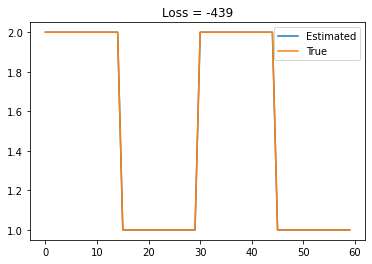

In [332]:
plt.plot(construct(true_vals, new_occurence_times), label='Estimated')
plt.plot(true_beta[::1000], label='True')
plt.legend()
plt.title('Loss = -439')

In [328]:
torch.tensor(true_beta[::1000].reshape(-1, 1))

tensor([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

In [321]:


pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, new_vals_tmp, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
cur_loss_tmp = np.inf
for epoch in range(100000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    new_occurence_times = np.array([ 17., 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]).astype(int)
    llik = new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls, sigma_torch,
                                ydata, CovAllDimensionsPyList, fOdeTorch,
                                priorTemperature, obs_per_day)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss_tmp
        if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
            break
        cur_loss_tmp = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 7712.941096289431
200 6573.362556482698
400 5708.995589171859
600 4964.190459586321
800 4332.72575592249
1000 3807.585944304698
1200 3379.6828492661707
1400 3037.324046554735
1600 2767.2943449687546
1800 2556.483541117871
2000 2393.1765227431715
2200 2267.6167554394165
2400 2171.932132371365
2600 2099.781059396167
2800 2046.0106980603782
3000 2006.4241294803421
3200 1977.6271607418773
3400 1956.9111995745993
3600 1942.1504346913466
3800 1931.703914989852
4000 1924.327095030367
4200 1919.1007864556823
4400 1915.3618146473327
4600 1912.645828482212
4800 1910.6345717469603
5000 1909.1189612325004
5200 1908.4891618323834


Text(0.5, 1.0, 'Loss = 1908')

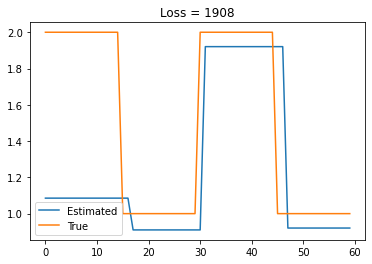

In [322]:
plt.plot(construct(new_vals_tmp, new_occurence_times), label='Estimated')
plt.plot(true_beta[::1000], label='True')
plt.legend()
plt.title('Loss = 1908')

In [ ]:
plt.plot(construct(torch.tensor(vals_ls[-4]).reshape(-1, 1), new_occurence_times), label='Estimated')
plt.plot(true_beta[::1000], label='True')
plt.legend()
plt.title('Loss = -331')

In [303]:
ls.reshape(len(ls), np.prod(ls.shape[1:]))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [304]:
ls.reshape(len(ls), -1)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [307]:
construct(torch.tensor(vals_ls[-4]).reshape(-1, 1), occurence_times_ls[-4].astype(int)).numpy().reshape(-1, 1)

array([[1.08540614],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [1.9271157 ],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [0.91023217],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [1.92062734],
       [0.920

In [ ]:
gradient
初始化 grad point first value
上一次
1.3.1 good initial point
1.3.4 bad initial point
周三 meeting 
